In [3]:
import pandas as pd
import nltk
nltk.download('stopwords')
import time
notebookstart= time.time()
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Gradient Boosting
#import lightgbm as lgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords
from string import punctuation

#HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /home/zyc62/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('demo10100.csv')

In [5]:
print("\nData Load Stage")
df = pd.read_csv('demo10100.csv',parse_dates = ["activation_date"])
df_index = df.index
print(df_index)

#testing = pd.read_csv('test.csv',parse_dates = ["activation_date"])
#testdex = testing.index
#test_item = testing['item_id']

y = df['deal_probability'].copy()
df.drop("deal_probability",axis=1, inplace=True)

#print('Train shape: {} Rows, {} Columns'.format(*training.shape))
#print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

df["price"] = np.log(df["price"]+0.001)               # filling in NaN's
df["price"].fillna(-999,inplace=True)
df["image_top_1"].fillna(-999,inplace=True)
df['param_1'].fillna('fill',inplace=True)
df['param_2'].fillna('fill',inplace=True)
df['param_3'].fillna('fill',inplace=True)

df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

import nltk
nltk.download('stopwords')

russian_stop = set(stopwords.words('russian','fill'))

df['desc_punctuation_cnt'] = df['description'].apply(lambda x: len("".join(_ for _ in str(x) if _ in punctuation)))
df['desc_upper_case_word_cnt'] = df['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.isupper()]))
df['stopword_count'] = df['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.lower() in russian_stop]))

df.drop(["activation_date","image"],axis=1,inplace=True)



Data Load Stage
RangeIndex(start=0, stop=10100, step=1)
[nltk_data] Downloading package stopwords to /home/zyc62/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
print("\nEncode Variables")
categorical = ["region","city","parent_category_name","category_name","user_type","image_top_1"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))

df['text_feat'] = df.apply(lambda row: ' '.join([
    str(row['param_1']),
    str(row['param_2']),
    str(row['param_3'])]),axis=1) # Group Param Features into a single string

df.drop(["param_1","param_2","param_3"],axis=1,inplace=True)


textfeats = ["description","text_feat", "title"]

for cols in textfeats:
    df[cols] = df[cols].astype(str)
    df[cols] = df[cols].astype(str).fillna('nicapotato') # WHY FILL NANS WITH NICAPOTATO?
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently

    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words



Encode Variables
Encoding : ['region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1']


In [7]:
tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


def get_col(col_name): return lambda x: x[col_name]

vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=16000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('text_feat',CountVectorizer(
            ngram_range=(1, 2),
            max_features=5000,
            preprocessor=get_col('text_feat'))),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            max_features=5000,
            preprocessor=get_col('title')))
    ])


start_vect=time.time()
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
print(ready_df.shape[0])

10100


In [8]:
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

df.drop(['item_id','description','title','text_feat'],axis=1,inplace=True)

df.drop('user_id',axis=1,inplace=True)

Vectorization Runtime: 0.05 Minutes


In [9]:
with pd.option_context('display.max_rows',50, 'display.max_columns', 50):
    display(df.head())

,Unnamed: 0,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,id,dullness,whiteness,average_pixel_width,blurrness,resnet50_score,Weekday,Weekd of Year,Day of Month,desc_punctuation_cnt,desc_upper_case_word_cnt,stopword_count,description_num_chars,description_num_words,description_num_unique_words,description_words_vs_unique,text_feat_num_chars,text_feat_num_words,text_feat_num_unique_words,text_feat_words_vs_unique,title_num_chars,title_num_words,title_num_unique_words,title_words_vs_unique
0,0,15,256,0,40,6.214610,21,1,1311,3314,84.56,0.00,4.33,632.23,0.43,1,13,28,2,0,1,49,7,7,100.000000,17,3,2,66.666667,29,5,5,100.0
1,1,3,102,2,4,9.210340,2,1,667,3002,0.00,0.00,1.48,453.89,0.39,1,12,21,1,0,0,27,3,3,100.000000,48,7,7,100.000000,38,5,5,100.0
2,2,10,241,0,43,7.346011,129,0,1246,1797,0.00,87.59,3.98,1654.58,1.00,5,11,18,2,0,6,128,23,22,95.652174,32,4,4,100.000000,10,2,2,100.0
3,3,22,478,7,33,-999.000000,2,1,228,4791,20.49,44.58,4.38,518.58,0.46,2,11,15,13,0,8,367,45,41,91.111111,16,3,2,66.666667,17,2,2,100.0
4,4,13,354,4,41,7.313221,12,1,1824,8583,1.08,87.29,4.26,383.30,0.47,1,12,21,3,1,2,66,9,9,100.000000,30,5,4,80.000000,18,3,3,100.0


In [10]:
df.drop(['Unnamed: 0','Weekday','Weekd of Year','Day of Month','description_num_chars','title_num_chars','id'],axis=1,inplace=True)

with pd.option_context('display.max_rows',50, 'display.max_columns', 50):
    display(df.head())
print(df.shape)

,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,dullness,whiteness,average_pixel_width,blurrness,resnet50_score,desc_punctuation_cnt,desc_upper_case_word_cnt,stopword_count,description_num_words,description_num_unique_words,description_words_vs_unique,text_feat_num_chars,text_feat_num_words,text_feat_num_unique_words,text_feat_words_vs_unique,title_num_words,title_num_unique_words,title_words_vs_unique
0,15,256,0,40,6.214610,21,1,1311,84.56,0.00,4.33,632.23,0.43,2,0,1,7,7,100.000000,17,3,2,66.666667,5,5,100.0
1,3,102,2,4,9.210340,2,1,667,0.00,0.00,1.48,453.89,0.39,1,0,0,3,3,100.000000,48,7,7,100.000000,5,5,100.0
2,10,241,0,43,7.346011,129,0,1246,0.00,87.59,3.98,1654.58,1.00,2,0,6,23,22,95.652174,32,4,4,100.000000,2,2,100.0
3,22,478,7,33,-999.000000,2,1,228,20.49,44.58,4.38,518.58,0.46,13,0,8,45,41,91.111111,16,3,2,66.666667,2,2,100.0
4,13,354,4,41,7.313221,12,1,1824,1.08,87.29,4.26,383.30,0.47,3,1,2,9,9,100.000000,30,5,4,80.000000,3,3,100.0


(10100, 26)


In [11]:
print("Modeling Stage")
#Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[df_index,:].values),ready_df[:df_index.shape[0]]]) # Sparse Matrix

#testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])

tfvocab = df.columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))

print("Feature Names Length: ",len(tfvocab))
#del df
gc.collect();

Modeling Stage
10100 Rows and 23022 Cols
Feature Names Length:  23022


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=100, random_state = 23)

In [13]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=False)
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [16]:
from sklearn import linear_model
from math import sqrt
from sklearn.decomposition import TruncatedSVD
def plot_ridge():
    ridge_rmse = []
    Dimension = []
    #Dimensionality reduction using TruncatedSVD
    for i in range(100,1000,100):
        svd = TruncatedSVD(n_components = i,random_state=42,n_iter = 7).fit(X_train_scaled)
        X_train_reduced = svd.transform(X_train_scaled)
        X_test_reduced = svd.transform(X_test_scaled)
        ridge_model = linear_model.Ridge(alpha = 5.0).fit(X_train_reduced,y_train)
        ridge_predicted = ridge_model.predict(X_test_reduced)
        ridge_rms = sqrt(mean_squared_error(y_test, ridge_predicted))
    #ridge_rmse.append(ridge_rms)
    #Dimension.append(i)
        print (i,ridge_rms)  
    #plt.plot(Dimension,ridge_rmse,label = "Ridge_RMSE")
    #plt.ylabel("RMSE")
   # plt.xlabel("Dimension_Size")
    #plt.legend()

plot_ridge()

100 0.24820717549028065
200 0.24318084592437347
300 0.23895234007579585
400 0.23575404327761934
500 0.24140817453987085
600 0.24533566070256463
700 0.23776091648414543
800 0.24004064464065264
900 0.23623558418549342


In [15]:
from sklearn import linear_model
from math import sqrt
from sklearn.decomposition import TruncatedSVD
def plot_ridge():
    #ridge_rmse = []
    #Dimension = []
    #Dimensionality reduction using TruncatedSVD
    for i in (1000,1200,1400,1600,1800,2000):    
        svd = TruncatedSVD(n_components= i, n_iter=7, random_state=42).fit(X_train_scaled)
        X_train_reduced = svd.transform(X_train_scaled)
        X_test_reduced = svd.transform(X_test_scaled)
        ridge_model = linear_model.Ridge(alpha = 5.0).fit(X_train_reduced,y_train)
        ridge_predicted = ridge_model.predict(X_test_reduced)
        ridge_rms = sqrt(mean_squared_error(y_test, ridge_predicted))
        print(i,ridge_rms)
        #ridge_rmse.append(ridge_rms)
        #Dimension.append(i)
        
    #plt.plot(Dimension,ridge_rmse,label = "Ridge_RMSE")
    #plt.ylabel("RMSE")
    #plt.xlabel("Dimension_Size")
    #plt.legend()

plot_ridge()

1000 0.24217298214060382
1200 0.24003459126389265
1400 0.23978360200610027
1600 0.24075052175474046
1800 0.23893520863060097
2000 0.2456604372941301


In [51]:
from sklearn import linear_model
from math import sqrt
from sklearn.decomposition import TruncatedSVD
def plot_ridge():
    ridge_rmse = []
    Dimension = []
    #Dimensionality reduction using TruncatedSVD
    for i in range(2000,11000,1000):
        svd = TruncatedSVD(n_components = i,random_state=42,n_iter = 7).fit(X_train_scaled)
        X_train_reduced = svd.transform(X_train_scaled)
        X_test_reduced = svd.transform(X_test_scaled)
        ridge_model = linear_model.Ridge(alpha = 5.0).fit(X_train_reduced,y_train)
        ridge_predicted = ridge_model.predict(X_test_reduced)
        ridge_rms = sqrt(mean_squared_error(y_test, ridge_predicted))
    #ridge_rmse.append(ridge_rms)
    #Dimension.append(i)
        print (i,ridge_rms)  
    #plt.plot(Dimension,ridge_rmse,label = "Ridge_RMSE")
    #plt.ylabel("RMSE")
   # plt.xlabel("Dimension_Size")
    #plt.legend()

plot_ridge()

2000 0.24566043729412906
3000 0.25317632542749346
4000 0.26653304615288864
5000 0.2728843276782871
6000 0.29207560067816213
7000 0.3197961810175255
8000 0.3655944843802622
9000 0.4243299652574728
10000 0.5937634340700518


In [53]:
from sklearn import linear_model
from math import sqrt
from sklearn.decomposition import TruncatedSVD
def plot_ridge():
    ridge_rmse = []
    Dimension = []
    #Dimensionality reduction using TruncatedSVD
    for i in (12000,14000,16000,18000,20000,22000):
        svd = TruncatedSVD(n_components = i,random_state=42,n_iter = 7).fit(X_train_scaled)
        X_train_reduced = svd.transform(X_train_scaled)
        X_test_reduced = svd.transform(X_test_scaled)
        ridge_model = linear_model.Ridge(alpha = 5.0).fit(X_train_reduced,y_train)
        ridge_predicted = ridge_model.predict(X_test_reduced)
        ridge_rms = sqrt(mean_squared_error(y_test, ridge_predicted))
    #ridge_rmse.append(ridge_rms)
    #Dimension.append(i)
        print (i,ridge_rms)  
    #plt.plot(Dimension,ridge_rmse,label = "Ridge_RMSE")
    #plt.ylabel("RMSE")
   # plt.xlabel("Dimension_Size")
    #plt.legend()

plot_ridge()


12000 0.5937634340700386
14000 0.5937634340699735
16000 0.5937634340700452
18000 0.5937634340700685
20000 0.5937634340700713
22000 0.5937634340700371


0.4110826517302157
[  804   889  1069  1342  2537  2600  3131  4736  5434  6679  6798  6966
  8420  8834  9268  9580  9702  9918 10346 10557 10658 10762 10781 11008
 11142 11534 12060 13855 14061 14244 14250 14710 14778 15002 15291 15610
 15661 15853 18412 18705 18706 18853 18928 18951 19378 19799 19851 19866
 19971 20447 20466 20620 20703 20794 20831 20919 21115 21221 21427 21428
 21663 21752 21788 21941 21959 21977 21998 22129 22224 22273 22395 22414
 22459 22469 22507 22800]
[3232 3814 4127]
[804, 889, 1069, 1342, 2537, 2600, 3131, 4736, 5434, 6679, 6798, 6966, 8420, 8834, 9268, 9580, 9702, 9918, 10346, 10557, 10658, 10762, 10781, 11008, 11142, 11534, 12060, 13855, 14061, 14244, 14250, 14710, 14778, 15002, 15291, 15610, 15661, 15853, 18412, 18705, 18706, 18853, 18928, 18951, 19378, 19799, 19851, 19866, 19971, 20447, 20466, 20620, 20703, 20794, 20831, 20919, 21115, 21221, 21427, 21428, 21663, 21752, 21788, 21941, 21959, 21977, 21998, 22129, 22224, 22273, 22395, 22414, 22459, 22469, 2

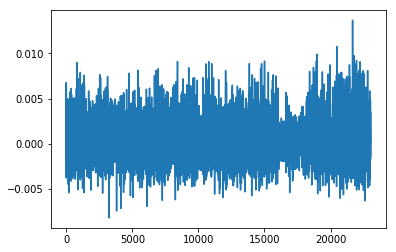

In [80]:
from sklearn import linear_model
from math import sqrt
from sklearn.decomposition import TruncatedSVD
def plot_ridge():
    
    #Dimensionality reduction using TruncatedSVD
    important_coefs =[]
    ridge_model = linear_model.Ridge(alpha = 5.0).fit(X_train_scaled,y_train)
    ridge_predicted = ridge_model.predict(X_test_scaled)
    ridge_rms = sqrt(mean_squared_error(y_test, ridge_predicted))
    #ridge_rmse.append(ridge_rms)
    #Dimension.append(i)
    print (ridge_rms)
    
    coef = ridge_model.coef_
    plt.plot(coef)
    for x in np.where(coef>0.007):
        print(x)
        for i in x:
            important_coefs.append(i)
    for x in np.where(coef<-0.007):
        print(x)
        for i in x:
            important_coefs.append(i)
        
    print(important_coefs)
    
    for i in important_coefs:
        print(tfvocab[i])
    
    
plot_ridge()

In [45]:
from sklearn import linear_model
from math import sqrt
from sklearn.decomposition import TruncatedSVD
def plot_ridge():
    
    #Dimensionality reduction using TruncatedSVD
    
    #svd = TruncatedSVD(n_components = 4000,random_state=42,n_iter = 7).fit(X_train_scaled)
    #X_train_reduced = svd.transform(X_train_scaled)
    #X_test_reduced = svd.transform(X_test_scaled)
    for i in (5.0,5.5,6.0):
        ridge_model = linear_model.Ridge(alpha = i).fit(X_train_scaled,y_train)
        ridge_predicted = ridge_model.predict(X_test_scaled)
        ridge_rms = sqrt(mean_squared_error(y_test, ridge_predicted))
    #ridge_rmse.append(ridge_rms)
    #Dimension.append(i)
        print (ridge_rms)  
    #plt.plot(Dimension,ridge_rmse,label = "Ridge_RMSE")
    #plt.ylabel("RMSE")
   # plt.xlabel("Dimension_Size")
    #plt.legend()
    #coef = ridge_model.coef_
    #plt.plot(coef)
    #for x in np.where(coef<-0.005):
        #print(x) 
    
plot_ridge()

0.41079761523667696
0.41070719267560213
0.4110070729369312
